## 1 - Initial analysis of the cropped Quotebank dataset

We have filtered out all the rows corresponding to quotes that did not contain any of the keywords related to gun control. The remaining rows have been added to a new file: 'quotes-cropped.json', which will be one of our main datasets for this project. It is much more reasonnable in size (550 Mo) than the full Quotebank dataset. This will allow us to work with Jupyter lab with all the data we need.

In [1]:
#Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Disable some pandas warnings we don't need
pd.options.mode.chained_assignment = None

# New dataframe with the data ('quotes-cropped.jspon')
df_original = pd.read_json('quotes-cropped.json', lines=True)

We will start by plotting the number of quotes containing at least one of our keywords over time (i.e. between 2015 and 2020). Even though some quotes will be irrelevant (e.g. "we were **shooting** a movie"), we assume the distribution of these irrelevant quotes to be close to uniform for the moment.

Our plot should therefore give a good first impression on how much people/the media has been speaking about gun control during these five years.

In [2]:
# Keep only the columns that we need for our initial analysis
df = df_original[['date','quotation']]

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

date                                          quotation
65127 2015-01-01 00:07:32  When we are face a suspect holding one of thes...
77653 2015-01-01 00:08:12  I expect much of the same from Edinburgh at Mu...
97745 2015-01-01 00:13:41  Of course the negative is if you need your gun...
45716 2015-01-01 00:13:41  Me personally, being a mother, when I sell a g...
79888 2015-01-01 00:14:39  We had a very good first half, and I thought w...

Now that we have sorted the dataframe by date, we can move on to the plot.

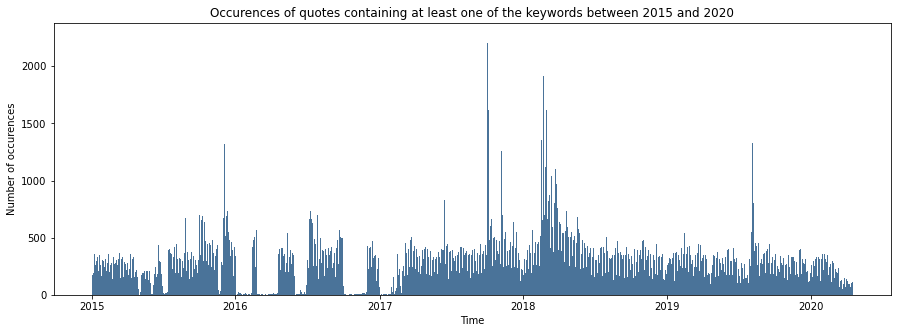

In [3]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.hist(df['date'], bins=2000, color='#4a7399')

plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

This histogram gives a good idea of how much people have been speaking of guns/firearms/shootings in the last 5 years in the media. **But it has a major flaw**: each quote has the same "weight" (one quote accounts for one occurence). But some quotes occure more often then others ('numOccurences' colum in the dataframe). We should take this extra information into account if we want a better view on the data.

We will now define a new dataframe that contains the number of quotes (multiplied by their respective occurences) for each day that contain at least one of the keywords.

In [4]:
# Define a new dataframe for this specific study
df = df_original[['date','numOccurrences']]

# We sum all the occurences of each date, and create a "sum" column in the dataframe
df = df['date'].dt.date.value_counts().rename('sum').to_frame()

# The dates are now the indices of the rows. We make them a column again.
df.index.name = 'date'
df.reset_index(inplace=True)

# Convert data column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort dataframe by date
df = df.sort_values(by=['date'])

df.head()

date  sum
1582 2015-01-01  141
1489 2015-01-02  167
1597 2015-01-03  135
1568 2015-01-04  145
1235 2015-01-05  221

We now have our desired dataframe: one row is one day, and for each day we have the number of quotes (multiplied by their occurences) that contain at least a keyword.

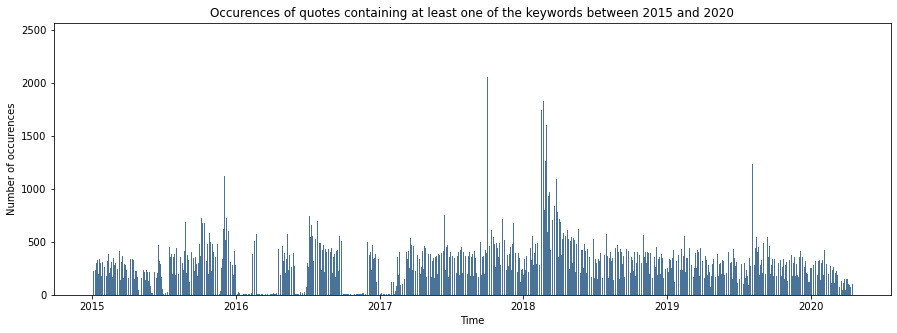

In [5]:
# Plotting number of quotes that contain keywords on the timeframe of the dataset
plt.figure(figsize=(15,5))

plt.bar(df['date'],df['sum'],color='#4a7399')
plt.title('Occurences of quotes containing at least one of the keywords between 2015 and 2020')
plt.xlabel('Time')
plt.ylabel('Number of occurences')
plt.show()

In the end, we see that this is plot is extremly similar to what we have obtained in the previous histogram. This is probably what data science is about sometimes... But at least we have cleared a possible source of error out of the way. We will be using this specific dataframe in the rest of the analysis.

In [6]:
# We will use this data in comparitive plots in part 3
backup1 = df[['date','sum']]

## 2 - Initial analysis of the "Mother Jone's" dataset

We have also proceeded to some initial analysis of the "Mother Jone's US Mass Shootings" dataset. Indeed, this dataset will give us some basic information about most shootings, such as: date, location, number of fatalities, number of injured, age of shooter, weapon type/legality...

In [7]:
# Reading the csv file
df = pd.read_csv('./Data/MassShootings.csv')

# Two new columns: location splitted into town and state
df[['town', 'state']] = df['location'].str.split(', ', expand = True)

# Convert date column to datetime format for better handling
df['date'] = pd.to_datetime(df['date'])

# Quotebank dataset is limited to years 2015-2021. Need to use same time span:
df = df.drop(df[df['date'].dt.year < 2015].index)
df = df.drop(df[df['date'].dt.year > 2020].index)

df.dtypes

case                                        object
location                                    object
date                                datetime64[ns]
summary                                     object
fatalities                                   int64
injured                                      int64
total_victims                                int64
location.1                                  object
age_of_shooter                              object
prior_signs_mental_health_issues            object
mental_health_details                       object
weapons_obtained_legally                    object
where_obtained                              object
weapon_type                                 object
weapon_details                              object
race                                        object
gender                                      object
sources                                     object
mental_health_sources                       object
sources_additional_age         

To give us a first glimpse at the data, we can plot the fatalities per shooting accross time, as well as the distribution of the number of fatalities per shooting.

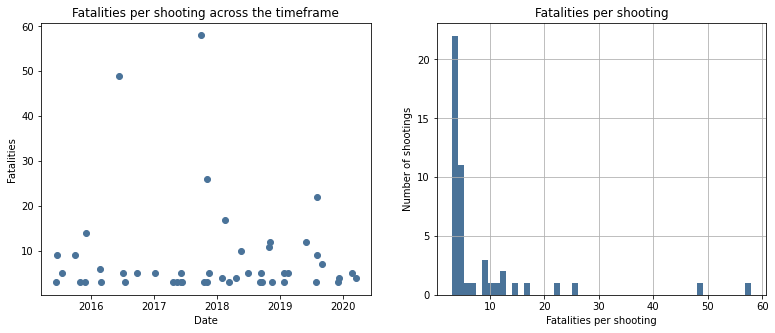

In [8]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

# Plot shootings in (time, number of fatalities) format
ax[0].scatter(df['date'], df['fatalities'], color='#4a7399')
ax[0].set_title('Fatalities per shooting across the timeframe')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Fatalities');

# Plot the distribution of the number of fatalities
ax[1] = df['fatalities'].hist(bins=50, color='#4a7399')
ax[1].set_xlabel('Fatalities per shooting')
ax[1].set_ylabel('Number of shootings')
ax[1].set_title('Fatalities per shooting');

There isn't much data, but we can say it seems to follow a power law: most of the shootings have a small number of fatalities (<10), but some large outliers are not unusual, some shootings having over 40 fatalities.

There are many paramters to explore, and one of them is **location** (as in the state) of the event:

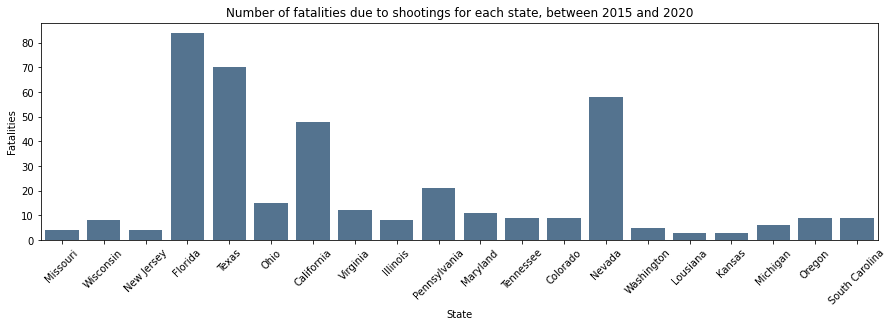

In [9]:
# Ploting the number of fatalities per state

fig, ax = plt.subplots(figsize=(15, 4))
ax = sns.barplot(y = df['fatalities'], x = df['state'], estimator = sum, ci = None, color='#4a7399')

ax.set_xlabel("State")
ax.set_ylabel("Fatalities")
ax.set_title("Number of fatalities due to shootings for each state, between 2015 and 2020")
plt.xticks(rotation=45)
plt.show()

With the above plot, we can clearly see that **states have been very unequally affected by mass shootings**. We will try to find some relevant correlations further on, such as average salary in the state, state political position (more of a 'blue state' or a 'red state'), etc. It will also be interesting to see how these parameters influence the media outrage after the shooting.

We will now have a quick look at other interesting information we have on each event: the **type of location** (Workplace, School...), wheather or not the weapons were obtained **legally**, etc.

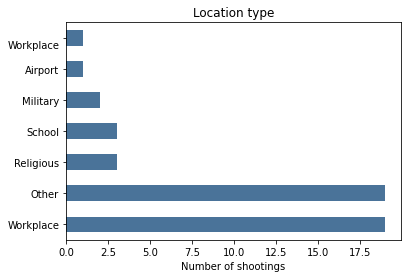

In [10]:
# Rename column location.1 to remove the dot
df.rename(columns={"location.1": "location1"}, inplace=True)
                   
df.location1.value_counts().plot(kind='barh',color='#4a7399')
plt.title('Location type')
plt.xlabel('Number of shootings')
plt.show()

In [11]:
# Check if the used weapons were obtained legally or not:
df.weapons_obtained_legally.value_counts().head()

Yes        25
TBD         7
-           6
No          4
Unknown     3
Name: weapons_obtained_legally, dtype: int64

As we can see, **most weapons that were used in the shootings were legally obtained** and licenced. It will be interesting later on to see if there is a correlation between this and how much the media speak of firearms after the event.

<AxesSubplot:ylabel='race'>

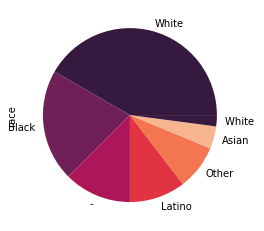

In [12]:
df.race.value_counts().plot(kind='pie',colors=sns.color_palette('rocket'))

Finally, we will use this dataframe in comparitive plots in part 3.<br>Therefore we save it to a new dataframe (in case we want to overwrite "df" further on):

In [13]:
backup2 = df[['date','fatalities']]

## 3 - Linking the two datasets

We will start by plotting a single timeline graph with the number of fatalities due to shootings over time, as well as the occurence of gun-related words in the media.

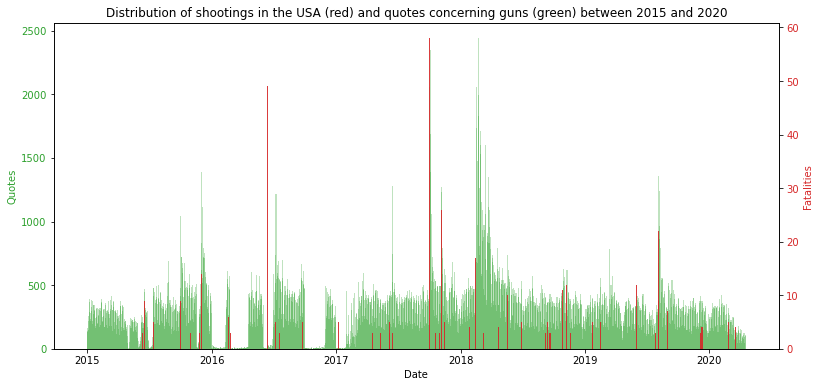

In [14]:
fig, ax1 = plt.subplots(figsize=(13,6))

# Plotting the quotes over time (green)
color = 'tab:green'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) between 2015 and 2020')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(backup1['date'], backup1['sum'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red)
color = 'tab:red'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(backup2['date'], backup2['fatalities'], color=color, alpha=0.9, width = 3)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

We can see several interesting events in this first plot. For example, the largest peak in fatalities happens around october 2017. It is followed by the second largest peak in quotes talking about guns.

In [15]:
# Print the largest shooting (most fatalities)
backup2 = backup2.sort_values(by='fatalities',ascending=False)
backup2 = backup2.reset_index(drop=True)
print("The largest shooting was:")
print(backup2.iloc[0])

# Quotes following the shooting (two days after)
backup1 = backup1.sort_values(by='sum',ascending=False)
print("\nThe corresponding peak in quotes discussing guns was:")
print(backup1.iloc[1])

The largest shooting was:
date          2017-10-01 00:00:00
fatalities                     58
Name: 0, dtype: object

The corresponding peak in quotes discussing guns was:
date    2017-10-03 00:00:00
sum                    2351
Name: 1, dtype: object


With the above print, we see that this peak is maximal exactly two days after the shooting.
 
Another interesting observation we can make is that the largest peak in quotes concerning guns takes place after a smaller shooting, in early 2018:

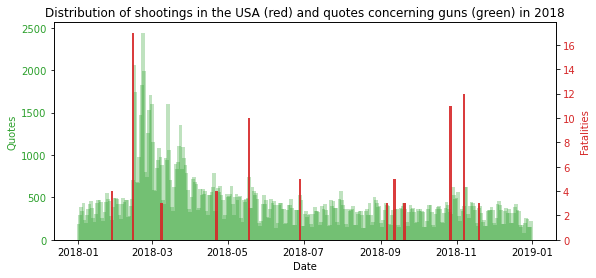

In [16]:
# We want to zoom in by looking only at 2018
backup1_2018 = backup1[(backup1['date'].dt.year==2018)]
backup2_2018 = backup2[(backup2['date'].dt.year==2018)]

fig, ax1 = plt.subplots(figsize=(9,4))

# Plotting the quotes over time (green barplot)
color = 'tab:green'
ax1.set_title('Distribution of shootings in the USA (red) and quotes concerning guns (green) in 2018')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quotes', color=color)
ax1.bar(backup1_2018['date'], backup1_2018['sum'], color=color, alpha=0.3, width = 3)
ax1.tick_params(axis='y', labelcolor=color)

# Same x-axis, but different y axis
ax2 = ax1.twinx()

# Plotting the fatalities due to shootings over time (red barplot)
color = 'tab:red'
ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
ax2.bar(backup2_2018['date'], backup2_2018['fatalities'], color=color, alpha=0.9, width = 2)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

It seams that this particular event has made much more noise then the others and over a larger period of time. The fact that it was **certainly not the shooting with the most fatalities** ("only" 17, compared to 58 for the max) shows that the number of fatalities is clearly not the only parameter that influences the media coverage of the event as well as the amplitude of the discussion on gun control afterwards.

**This makes us want to investigate further: what are the other factors that can explain these differences?** Some ideas: 
- Location of the shooting (what state, but also what type of place: e.g. at a school, workplace...)
- Wheather of not the weapon was bought legally
- Age, gender and ethnicity of the shooter and/or the victims
- The type of weapon that was used
- etc.

**Selecting the timeframe following each shooting**<br>
In order to analyse the media's response to each shooting, we can start by selecting only the quotes from the following N days (for the moment we chose N=10). We did this for the top 3 most lethal shootings and plotted the results below. These again emphasize the idea that there is much more than just the number of fatalities.

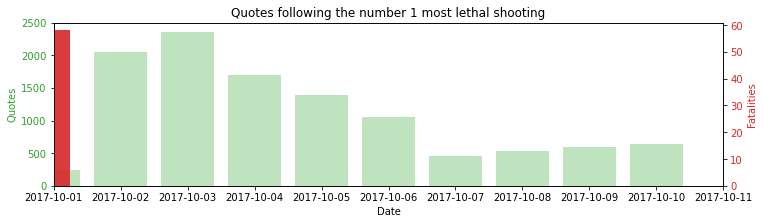

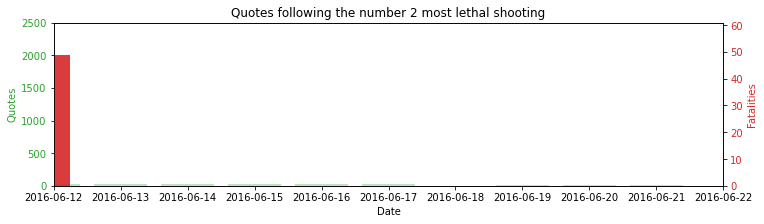

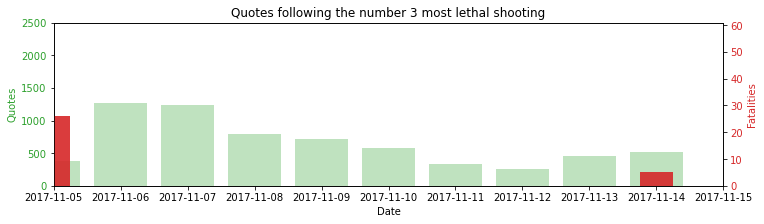

In [17]:
# We want to zoom in for the 10 days after each shooting
from datetime import timedelta

for i in range(0,3):
    
    # Get the date of the (i+1)th most lethal shooting
    shooting_date = backup2.sort_values(by='fatalities',ascending=False)['date'].iloc[i]
    
    # Select only the quotes in the 10 days following the selected shooting
    shooting_after =  backup1[((backup1['date'] >= shooting_date))]
    shooting_after =  shooting_after[(shooting_after['date'] < shooting_date + timedelta(days=10))]

    fig, ax1 = plt.subplots(figsize=(12,3))
    
    # Plotting the quotes over time (green barplot)
    color = 'tab:green'
    ax1.set_title('Quotes following the number ' + str(i+1) + ' most lethal shooting')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quotes', color=color)
    ax1.bar(shooting_after['date'], shooting_after['sum'], color=color, alpha=0.3, width = 0.8)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(shooting_date,shooting_date+ timedelta(days=10))
    ax1.set_ylim(0,2500)
    
    # Same x-axis, but different y axis
    ax2 = ax1.twinx()
    
    # Plotting the fatalities due to shootings over time (red barplot)
    color = 'tab:red'
    ax2.set_ylabel('Fatalities', color=color)  # we already handled the x-label with ax1
    ax2.bar(backup2['date'], backup2['fatalities'], color=color, alpha=0.9, width = 0.5)
    ax2.tick_params(axis='y', labelcolor=color)

plt.show()